In [1]:
"""%load_ext autoreload
%autoreload 2"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys

%load_ext autoreload
%autoreload 1
%aimport main_exp
import main_exp
%aimport main_ode
import main_ode

import seaborn as sns
# Set seaborn style as default
sns.set(style="whitegrid")
# Adjust font sizes globally
plt.rcParams.update({
    "font.size": 14,  # Base font size
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 14,  # Label font size
    "xtick.labelsize": 12,  # X-axis tick label size
    "ytick.labelsize": 12,  # Y-axis tick label size
    "legend.fontsize": 12  # Legend font size
})

SLURM_CPUS_PER_TASK: 0
OMP_NUM_THREADS: 0
os.cpu_count(): 10
[JAX CONFIG] Using 10 CPU threads


In [7]:
T=3
lr=1.0

r_1=1.0
r_2=50.0
r_12=0.0
tau_1=1.0
tau_2=1.0


D=1000
n=5
epochs=100
savepoints=100

In [8]:
teacher = main_exp.create_teacher(D, main_exp.create_key(main_exp.random_seed()))
students_1 = main_exp.create_student(D, n, main_exp.create_key(main_exp.random_seed()))
students_2 = main_exp.create_student(D, n, main_exp.create_key(main_exp.random_seed()))


In [9]:
J_1, J_2, Q_1, Q_2, Q_12 = main_exp.order_params_ode(students_1, students_2, teacher, D)
J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init = J_1[0], J_2[0], Q_1[0], Q_2[0], Q_12[0]
S = np.einsum('D,D->', teacher, teacher) / D

print(J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init)

J_1_s, J_2_s, Q_1_s, Q_2_s, Q_12_s = main_exp.Run_simulation(D, n, lr, teacher, students_1, students_2, T, r_1, r_2, r_12, tau_1, tau_2, epochs, savepoints)

0.005373783 -0.0132109905 0.99777126 0.9670682 -0.0010853688


In [10]:
#J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init = J_1_s[1,0], J_2_s[1,0], Q_1_s[1,0], Q_2_s[1,0], Q_12_s[1,0]

J_1_s_ode, J_2_s_ode, Q_1_s_ode, Q_2_s_ode, Q_12_s_ode = main_ode.ODE_solver(lr, T, r_1, r_2, r_12, tau_1, tau_2, 1/D, epochs, savepoints, 
               J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init, S)

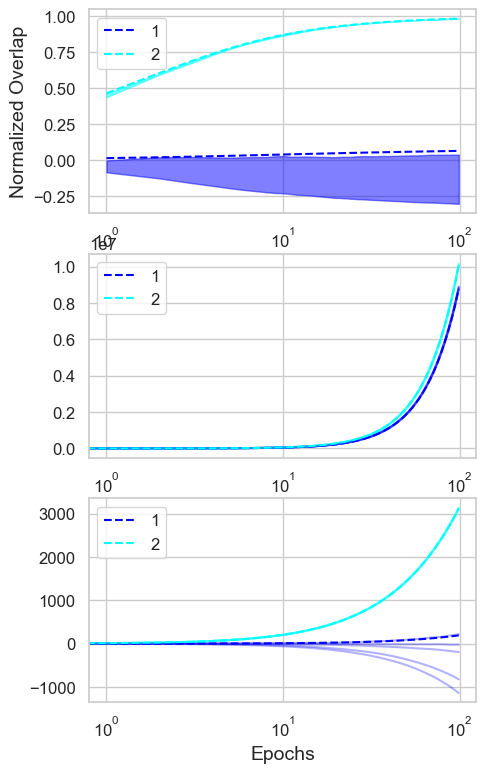

In [11]:
import numpy as np
log_epochs = np.unique(np.logspace(0, np.log10(epochs - 1), num=savepoints, dtype=int))
log_epochs_0 = np.concatenate((np.array([0]), log_epochs))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 9))
# calculate normalized overlap
overlaps_1 = J_1_s / (np.sqrt(Q_1_s * S))
mean_overlaps_1 = np.mean(overlaps_1, axis=1)
std_overlaps_1 = np.std(overlaps_1, axis=1)

overlaps_2 = J_2_s / (np.sqrt(Q_2_s * S))
mean_overlaps_2 = np.mean(overlaps_2, axis=1)
std_overlaps_2 = np.std(overlaps_2, axis=1)

overlaps_1_ode = J_1_s_ode / (np.sqrt(Q_1_s_ode * S))
overlaps_2_ode = J_2_s_ode / (np.sqrt(Q_2_s_ode * S))

e = len(log_epochs_0)

#ax1.plot(mean_overlaps, label='Mean Overlap', color='blue')
ax1.fill_between(log_epochs[:e], mean_overlaps_1[1:e] - std_overlaps_1[1:e], mean_overlaps_1[1:e] + std_overlaps_1[1:e], color='blue', alpha=0.5)
ax1.fill_between(log_epochs[:e], mean_overlaps_2[1:e] - std_overlaps_2[1:e], mean_overlaps_2[1:e] + std_overlaps_2[1:e], color='cyan', alpha=0.5)
ax1.set_ylabel('Normalized Overlap')
ax1.plot(log_epochs[:e], overlaps_1_ode[1:e], label='1', color='blue', linestyle='--')
ax1.plot(log_epochs[:e], overlaps_2_ode[1:e], label='2', color='cyan', linestyle='--')
ax1.set_xscale('log')
ax1.legend()

#ax1.fill_between(log_epochs_0, mean_overlaps_1 - std_overlaps_1, mean_overlaps_1 + std_overlaps_1, color='blue', alpha=0.5)
"""for i in range(n):
    ax1.plot(log_epochs_0[0:e], overlaps_1[0:e, i], color='blue', alpha=0.3)
    ax1.plot(log_epochs_0[0:e], overlaps_2[0:e, i], color='cyan', alpha=0.3)
ax1.set_ylabel('Normalized Overlap')
ax1.plot(log_epochs_0[0:e], overlaps_1_ode[0:e], label='1', color='blue', linestyle='--')
ax1.plot(log_epochs_0[0:e], overlaps_2_ode[0:e], label='2', color='cyan', linestyle='--')
ax1.set_xscale('log')
ax1.legend()"""


for i in range(n):
    ax2.plot(log_epochs_0[0:e], Q_1_s[0:e, i], color='blue', alpha=0.3)
    ax2.plot(log_epochs_0[0:e], Q_2_s[0:e, i], color='cyan', alpha=0.3)

ax2.plot(log_epochs_0[0:e], Q_1_s_ode[0:e], label='1', color='blue', linestyle='--')
ax2.plot(log_epochs_0[0:e], Q_2_s_ode[0:e], label='2', color='cyan', linestyle='--')
ax2.set_xscale('log')
ax2.legend()
"""#ax2.plot(jnp.mean(R_s, axis=1), label='Mean R_s', color='red')
ax2.fill_between(log_epochs, jnp.mean(R_s, axis=1) - jnp.std(R_s, axis=1), jnp.mean(R_s, axis=1) + jnp.std(R_s, axis=1), color='red', alpha=0.2)
ax2.plot(log_epochs, R_s_ode, label='R_s ODE', color='red', linestyle='--')
ax2.set_ylabel('Mean R_s')
ax2.set_xscale('log')
ax2.legend()



#ax3.plot(jnp.mean(Qr_s, axis=1), label='Mean Qr_s', color='green')
ax3.fill_between(log_epochs, jnp.mean(Qr_s, axis=1) - jnp.std(Qr_s, axis=1), jnp.mean(Qr_s, axis=1) + jnp.std(Qr_s, axis=1), color='green', alpha=0.2)
#ax3.plot(jnp.mean(Qi_s, axis=1), label='Mean Qi_s', color='orange')
ax3.fill_between(log_epochs, jnp.mean(Qi_s, axis=1) - jnp.std(Qi_s, axis=1), jnp.mean(Qi_s, axis=1) + jnp.std(Qi_s, axis=1), color='orange', alpha=0.2)
ax3.plot(log_epochs, Q_s_r_ode, label='Qr_s ODE', color='green', linestyle='--')
ax3.plot(log_epochs, Q_s_i_ode, label='Qi_s ODE', color='orange', linestyle='--')
ax3.set_ylabel('Mean Q_s')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()"""

for i in range(n):
    ax3.plot(log_epochs_0[0:e], J_1_s[0:e, i], color='blue', alpha=0.3)
    ax3.plot(log_epochs_0[0:e], J_2_s[0:e, i], color='cyan', alpha=0.3)

ax3.plot(log_epochs_0[0:e], J_1_s_ode[0:e], label='1', color='blue', linestyle='--')
ax3.plot(log_epochs_0[0:e], J_2_s_ode[0:e], label='2', color='cyan', linestyle='--')
ax3.set_xscale('log')
ax3.legend()

plt.xlabel('Epochs')
plt.show()

In [46]:
print(overlaps_1_ode[50:])

[nan nan nan nan nan]


In [ ]:
"""run backward ode from end result of simulation"""

J_1_end, J_2_end, Q_1_end, Q_2_end, Q_12_end = J_1_s[-1, 0], J_2_s[-1, 0], Q_1_s[-1, 0], Q_2_s[-1, 0], Q_12_s[-1, 0]

J_1_s_ode, J_2_s_ode, Q_1_s_ode, Q_2_s_ode, Q_12_s_ode = main_ode.ODE_solver(lr, T, r_1, r_2, r_12, tau_1, tau_2, 1/D, epochs, savepoints,
               J_1_end, J_2_end, Q_1_end, Q_2_end, Q_12_end, S)

J_1_s_ode = J_1_s_ode[::-1]
J_2_s_ode = J_2_s_ode[::-1]
Q_1_s_ode = Q_1_s_ode[::-1]
Q_2_s_ode = Q_2_s_ode[::-1]
Q_12_s_ode = Q_12_s_ode[::-1]

AttributeError: module 'main_ode' has no attribute 'ODE_solver_backward'

In [11]:
print(main_exp.__file__)

/nfs/nhome/live/npatel/projects/Collective-learning-/main_exp.py


In [13]:
!tail -n 50 main_exp.py


"""
run the simulation for single set of parameters and given number of epochs, 
and store the order parameters at logarithmically spaced intervals
"""
def Run_simulation(D, n, lr, teacher, students_1, students_2, T, r_1, r_2, r_12, tau_1, tau_2, epochs, savepoints):

    log_keys = np.unique(np.logspace(0, np.log10(epochs - 1), num=savepoints, dtype=int))
    save_number = len(log_keys)
    log_keys = jnp.array(log_keys)
    log_values = jnp.arange(save_number, dtype=int)

    J_1_s = jnp.zeros((save_number+1, n))
    J_2_s = jnp.zeros((save_number+1, n))
    Q_1_s = jnp.zeros((save_number+1, n))
    Q_2_s = jnp.zeros((save_number+1, n))
    Q_12_s = jnp.zeros((save_number+1, n))

    J_1, J_2, Q_1, Q_2, Q_12 = order_params_ode(students_1, students_2, teacher, D)

    for epoch in range(epochs):
        index = lookup_index(epoch, log_keys, log_values)
        J_1_s = J_1_s.at[index, :].set(J_1)
        J_2_s = J_2_s.at[index, :].set(J_2)
        Q_1_s = Q_1_s.at[index, :].set(Q_1)
 

In [35]:
print(J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init)
print(J_1_s[0,:], J_2_s[0,:], Q_1_s[0,:], Q_2_s[0,:], Q_12_s[0,:])

0.0027797318 0.05160381 1.0021038 0.993683 0.027838845
[0.00277973 0.00277973 0.00277973 0.00277973 0.00277973 0.00277973
 0.00277973 0.00277973 0.00277973 0.00277973] [0.05160381 0.05160381 0.05160381 0.05160381 0.05160381 0.05160381
 0.05160381 0.05160381 0.05160381 0.05160381] [1.0021038 1.0021038 1.0021038 1.0021038 1.0021038 1.0021038 1.0021038
 1.0021038 1.0021038 1.0021038] [0.993683 0.993683 0.993683 0.993683 0.993683 0.993683 0.993683 0.993683
 0.993683 0.993683] [0.02783884 0.02783884 0.02783884 0.02783884 0.02783884 0.02783884
 0.02783884 0.02783884 0.02783884 0.02783884]


In [33]:
print(J_1_s_ode[0], J_2_s_ode[0], Q_1_s_ode[0], Q_2_s_ode[0], Q_12_s_ode[0])

-0.04451909 -0.0076649617 1.1241591 1.0456656 0.005360129


In [42]:
print(Q_2_s[0,:])

[0.993683 0.993683 0.993683 0.993683 0.993683 0.993683 0.993683 0.993683
 0.993683 0.993683]


In [40]:
print(std_overlaps_1)

[0.         0.0079984  0.01324025 0.01598729 0.01538064 0.01776691
 0.02156828 0.02307669 0.02435668 0.02520745 0.02775661 0.02852902
 0.03236831 0.03203474 0.02988259 0.03234998 0.03574503 0.03408716
 0.03558765 0.03682774 0.03671344 0.04104658 0.04319979 0.04544762
 0.04767666 0.04943725 0.05088972 0.05000968 0.04999026 0.05103023
 0.05300508 0.05274189 0.05332184 0.05159281 0.05250792 0.05356373
 0.05378838 0.05391316 0.05528296 0.05605389 0.05698605 0.05689562
 0.05749978 0.05851581 0.0593871  0.05970019 0.06063158 0.06064002
 0.06073079 0.06098344 0.0616007  0.06238977 0.06256145 0.06328123
 0.06357629]
